USAGE: (Once you change the ticker, you’re good to go)

1 – Monthly Boxplot
Shows the distribution of monthly returns for each calendar month. Helps quickly identify which months tend to have positive/negative returns and how volatile they are.

2 – ADF Test (Augmented Dickey–Fuller)
Checks whether the time series is stationary or follows a random walk. Useful to distinguish between a mean-reverting series and one that drifts freely.

3 – Decomposition (trend + residuals)
Splits the series into a long-term component (trend) and an unexplained part (residuals). Residuals capture sudden shocks and volatility.

4 – Price vs. Deseasonalized Price
Compares the observed price with the price adjusted for the estimated seasonal component. Helps reveal if removing seasonality changes the signal.

5 – October Effect
Analyzes October returns in detail: statistics, distribution, comparison with other months, and a regression to evaluate October’s impact on the yearly performance.

6 – Similar Years (Jan–Sep)
Compares the January–September pattern of the current year with the same period in past years using correlation. Highlights the “most similar years” and how they performed from October to December — useful for historical analogy.

7 – Up/Down Transition Matrix
Calculates conditional probabilities of moving from an Up or Down day to the next. The heatmap shows the likelihood of a positive or negative day depending on the previous day’s result.

8 – Rebound Probability After Down-Streaks
Analyzes consecutive negative days and computes the probability that the following day is positive. Shows whether the chance of a rebound increases after 2–3–4 straight losses.

9 – Sign Autocorrelation
Computes the autocorrelation of return signs (+1=up, –1=down). Measures whether sequences show memory: positive values = momentum (persistence), negative values = mean reversion (inversion).

10 – Rolling Conditional Probabilities (P(Up|Up) and P(Up|Down))
Estimates dynamically (using a one-year rolling window) the probability of an up day after an up day, and the probability of an up day after a down day. The two curves highlight whether momentum or mean reversion dominates in different market phases.

In [2]:
pip install yfinance

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import scipy.stats as ss
from statsmodels.tsa.seasonal import STL

plt.rcParams["figure.figsize"] = (12, 5)

In [15]:
SYMBOL      = "TSLA"     # <— cambia il ticker qui
START_DATE  = "2000-01-01"
END_DATE    = None
TOP_N_YEARS = 3
CORR_METHOD = "pearson"  # "pearson" ma viene utilizzato anche "spearman"
OCT_THRESHOLD = 0.0
ACF_LAGS    = 20
ROLL_WIN    = 252

/tmp/ipython-input-1017969046.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False)


TSLA — osservazioni: 3836 | da 2010-06-29 a 2025-09-26


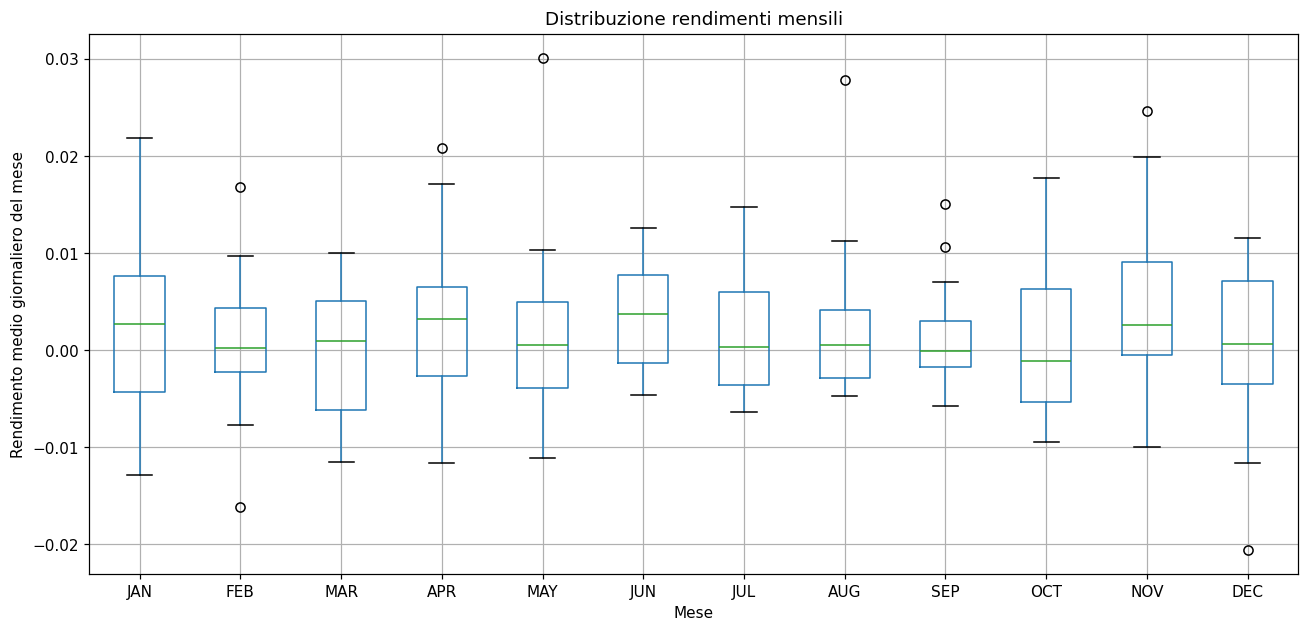


=== Augmented Dickey–Fuller su prezzi (TSLA) ===
ADF Statistic: -0.506606
p-value: 0.890721
Critical Values:
  1%: -3.432
  5%: -2.862
  10%: -2.567


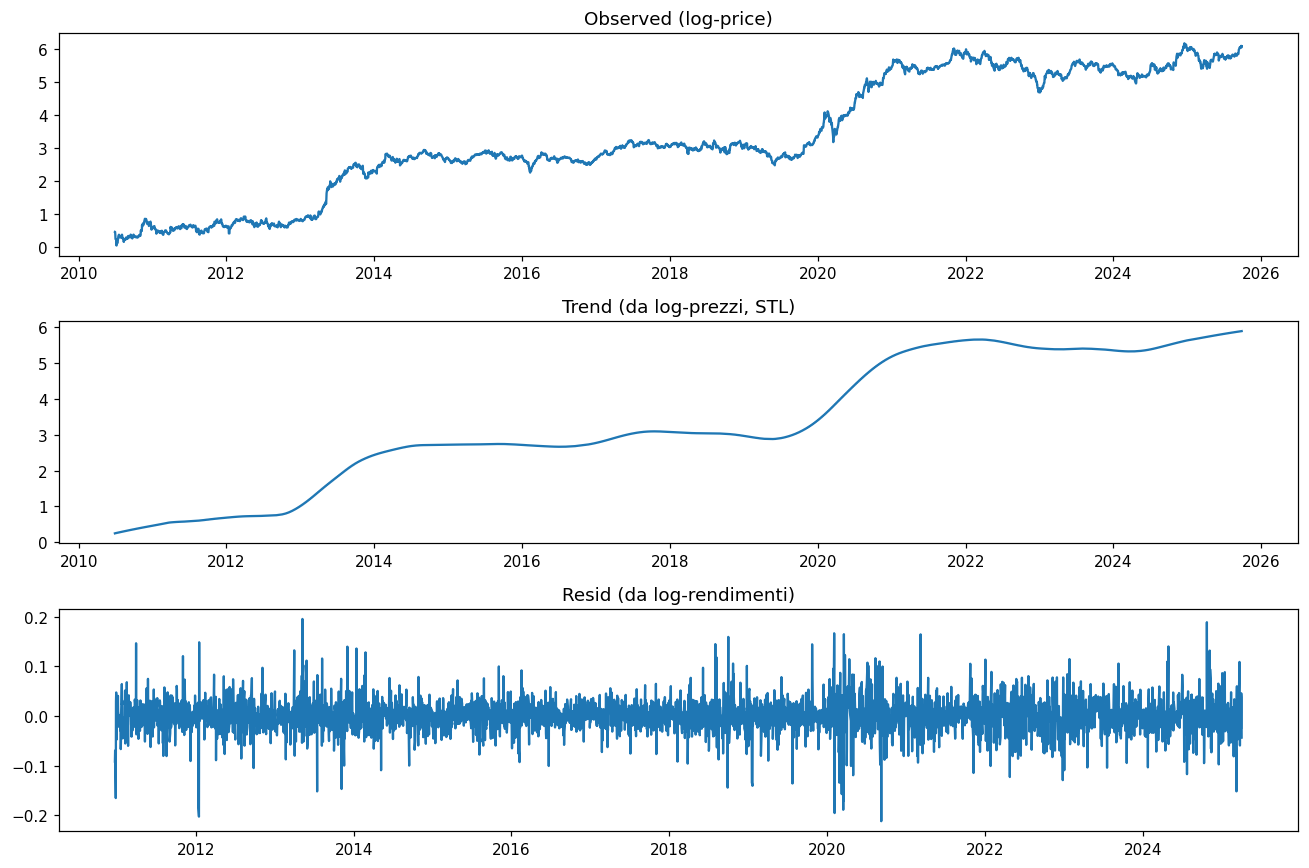

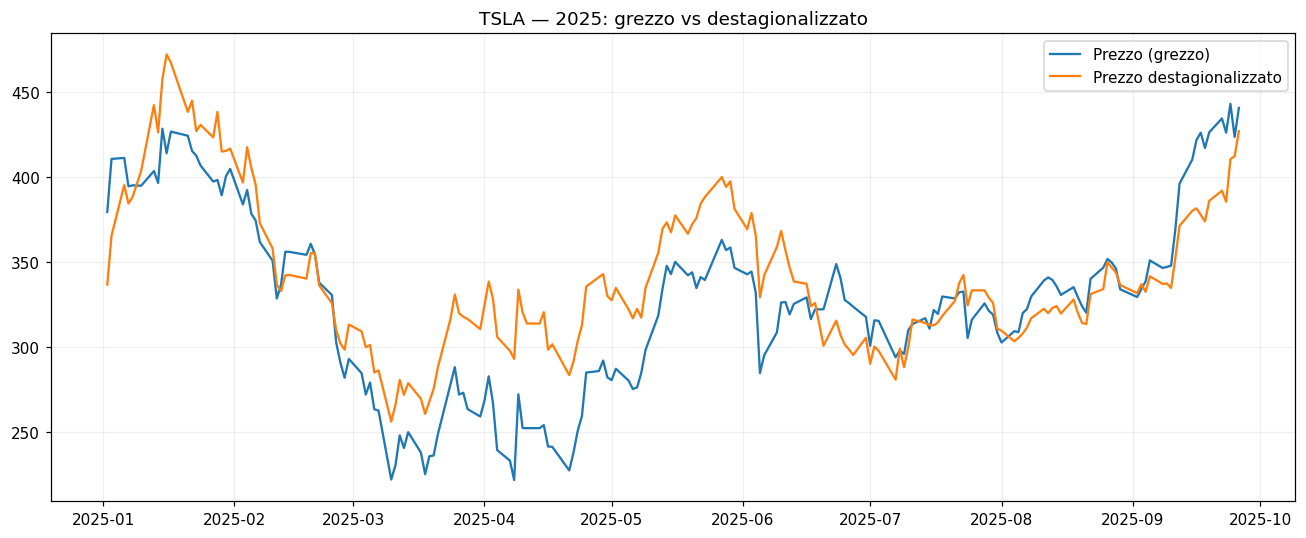

/tmp/ipython-input-1017969046.py:112: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sum = r.resample("M").sum()
/tmp/ipython-input-1017969046.py:138: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly = r.resample("Y").sum()



=== Statistiche OTTOBRE (per anno) ===
count    15.000000
mean      0.021578
std       0.183603
min      -0.208376
25%      -0.113189
50%      -0.024288
75%       0.132255
max       0.373176
Name: Oct_Return, dtype: float64
Hit rate (anni con ottobre > 0): 40.0%
Differenza media (Ottobre - media altri mesi): -0.0253


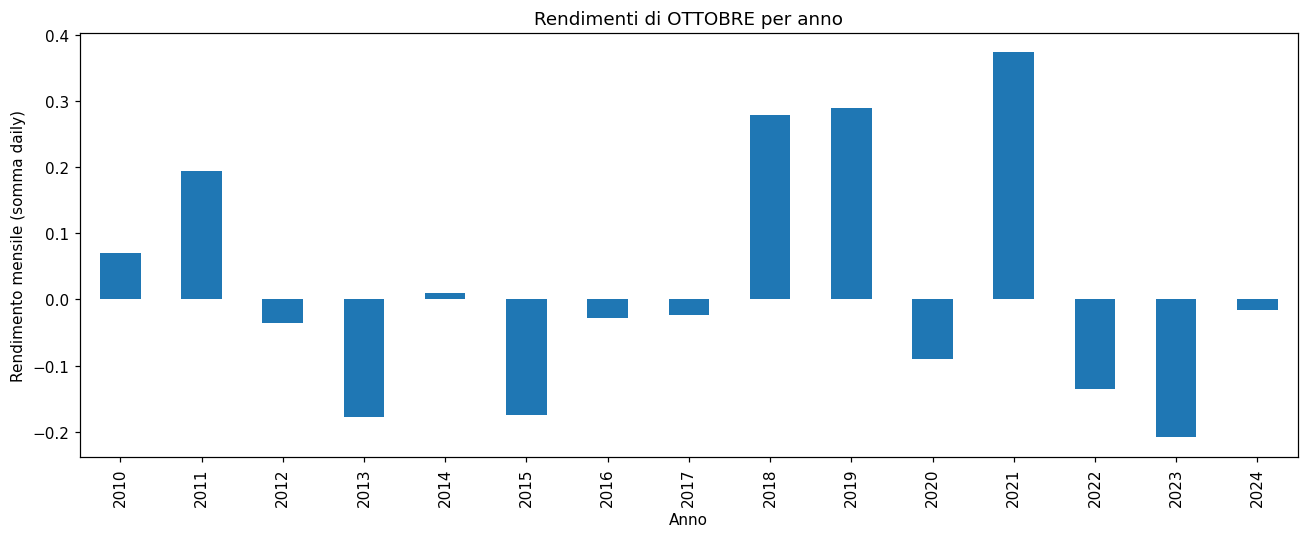

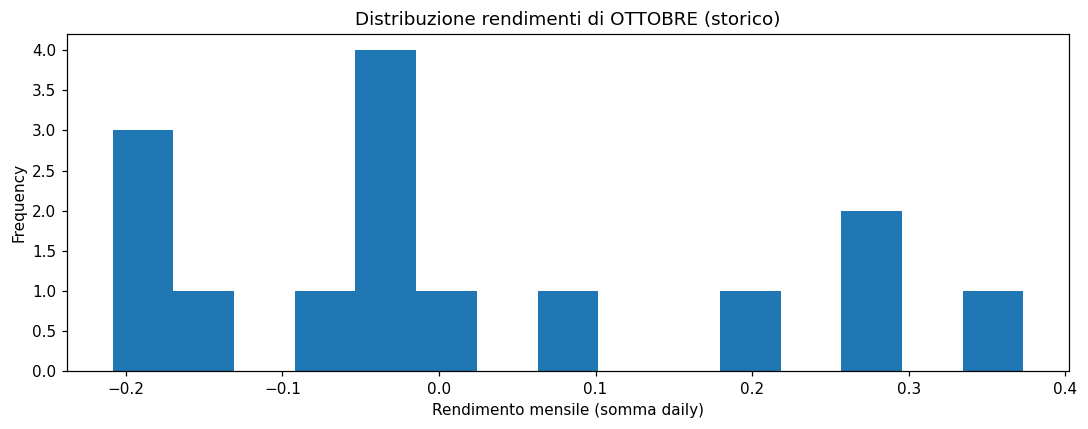


=== Regressione OLS: Y (annuo) ~ const + Oct ===
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.5448
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.474
Time:                        15:23:46   Log-Likelihood:                -16.503
No. Observations:                  15   AIC:                             37.01
Df Residuals:                      13   BIC:                             38.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

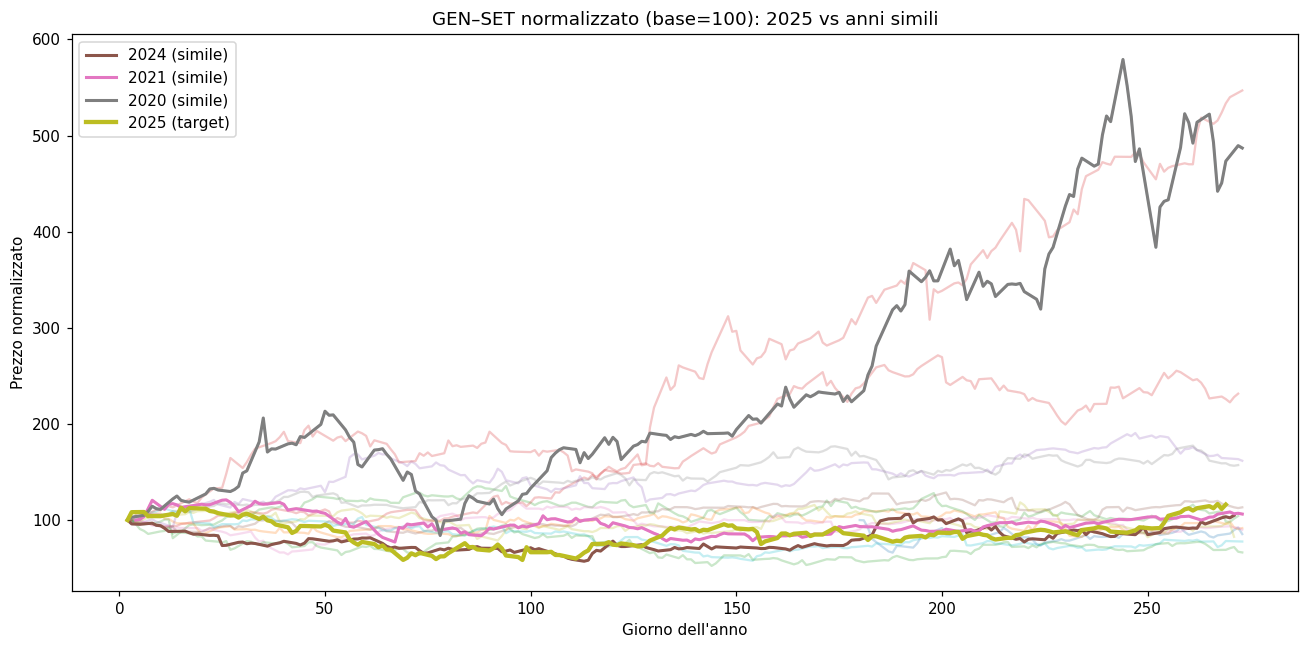

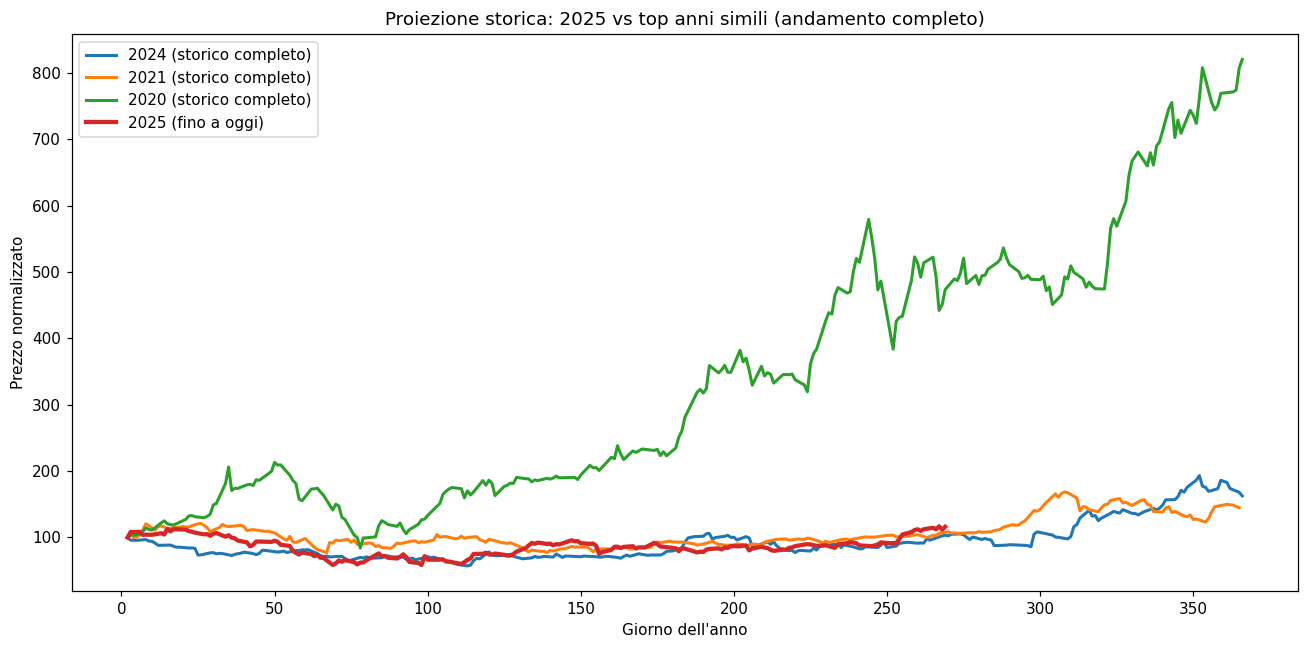


Rendimenti storici Oct–Dec nei top anni simili:
 year  Oct–Dec %
 2020  64.488011
 2024  54.355383
 2021  36.320011


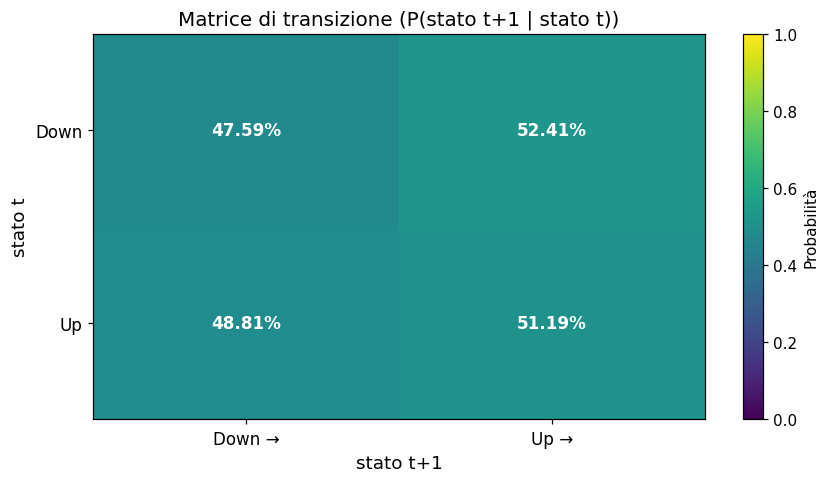


Conteggi di transizione (righe = stato t, colonne = stato t+1):
      Down    Up
Down   878   967
Up     966  1013

Probabilità condizionali P(stato t+1 | stato t):
        Down      Up
Down  0.4759  0.5241
Up    0.4881  0.5119


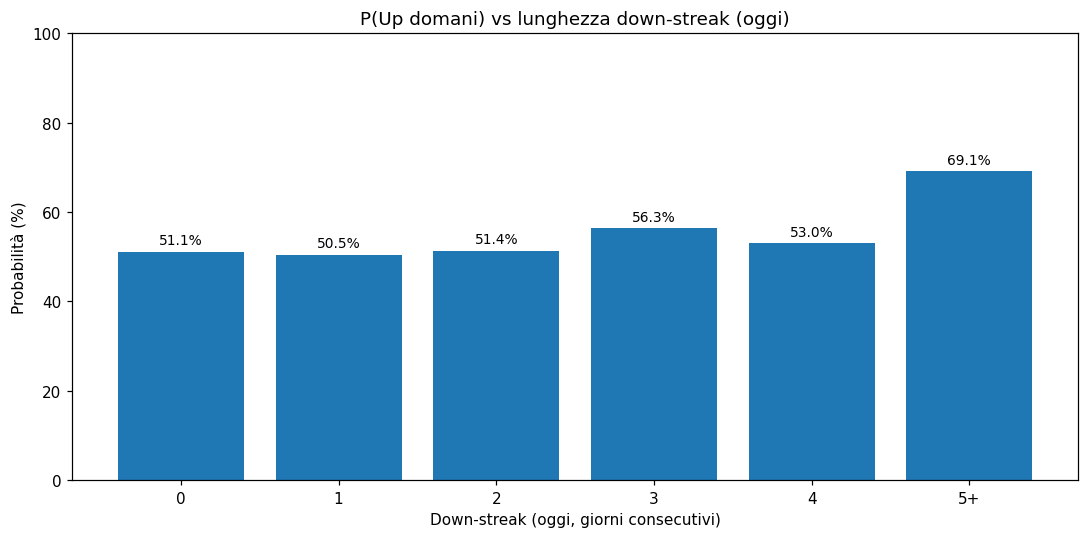

/tmp/ipython-input-1017969046.py:470: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print(out.fillna(0).to_string())


     count  up_next  prob_up (%)
bin                             
0     1990     1016    51.055276
1      971      490    50.463440
2      477      245    51.362683
3      229      129    56.331878
4      100       53    53.000000
5+      68       47    69.117647


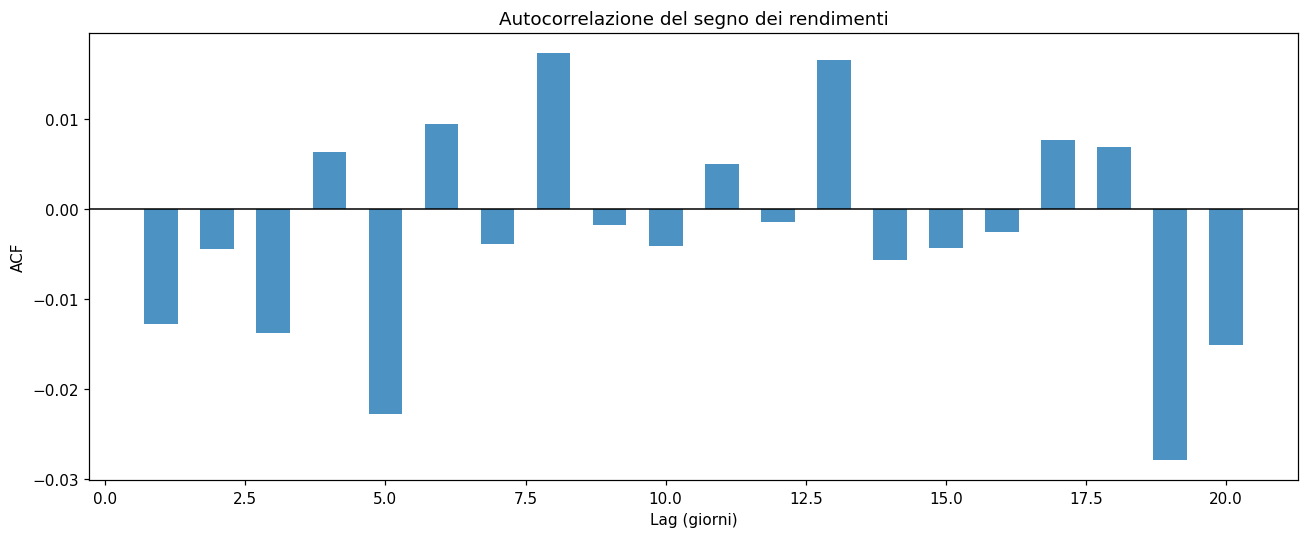

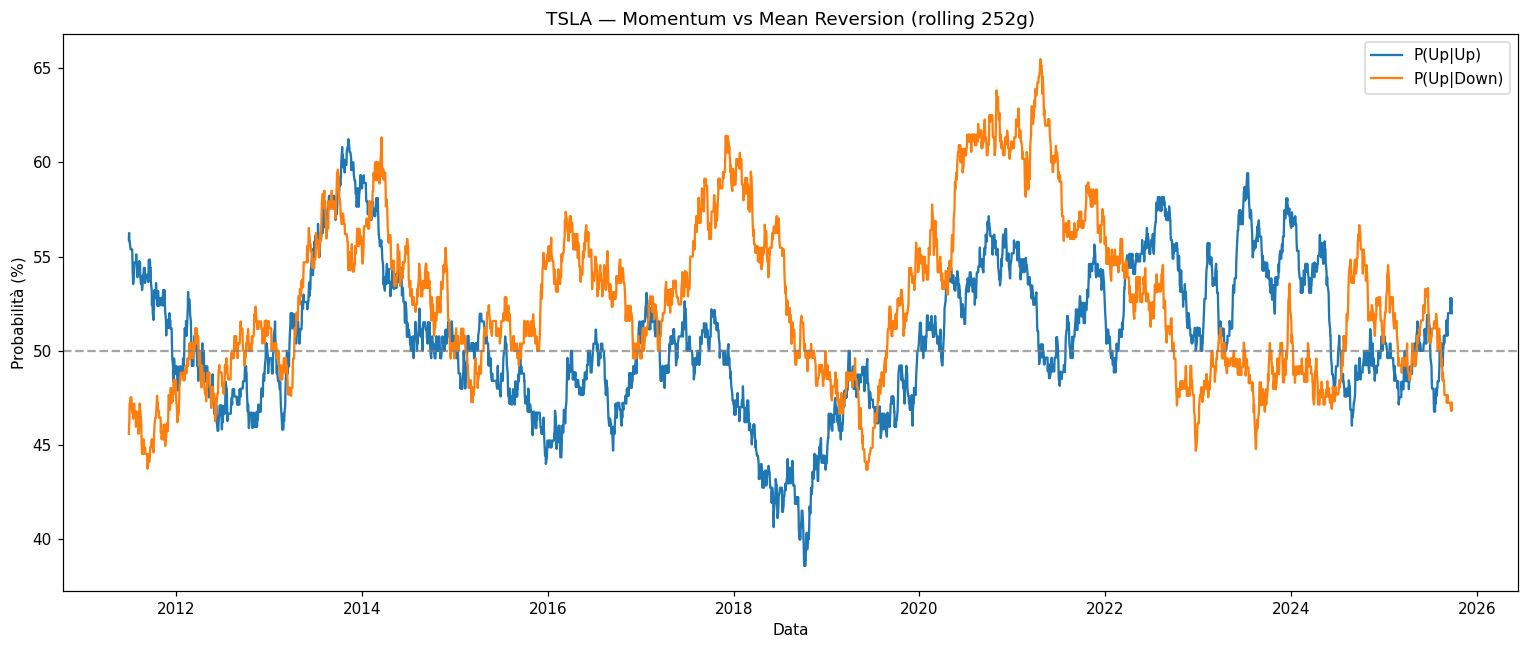

In [16]:
data = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False)
if data.empty:
    raise ValueError(f"Nessun dato per {SYMBOL}.")
# Preferisci la 'Close' se presente e pulisci
if isinstance(data, pd.DataFrame):
    if "Close" in data.columns:
        stock = data["Close"].copy().dropna()
    elif "Adj Close" in data.columns:
        stock = data["Adj Close"].copy().dropna()
    else:
        stock = data.iloc[:, 0].copy().dropna().squeeze()
else:
    stock = data.dropna()

stock = stock.sort_index()
print(f"{SYMBOL} — osservazioni: {len(stock)} | da {stock.index.min().date()} a {stock.index.max().date()}")

# ===========================
# 1) BOXPLOT RENDIMENTI MENSILI
# ===========================
r_daily = stock.pct_change()
monthly_returns = r_daily.groupby([r_daily.index.year, r_daily.index.month]).mean()
monthly_returns.index = monthly_returns.index.set_names(["Year", "Month"])
monthly_df = monthly_returns.reset_index().dropna()
monthly_df.columns = ["Year", "Month", "Monthly_Return"]
monthly_df["Monthly_Return"] = monthly_df["Monthly_Return"].astype(float).clip(-0.5, 0.5)

ax = monthly_df.boxplot(column="Monthly_Return", by="Month", figsize=(12, 6))
ax.set_xlabel("Mese")
ax.set_ylabel("Rendimento medio giornaliero del mese")
ax.set_title("Distribuzione rendimenti mensili")
plt.suptitle("")
ax.set_xticklabels(['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'])
plt.tight_layout()
plt.show()

# ===========================
# 2) TEST ADF (STAZIONARIETÀ) sui prezzi
# ===========================
adf_res = adfuller(stock)
print(f"\n=== Augmented Dickey–Fuller su prezzi ({SYMBOL}) ===")
print(f"ADF Statistic: {adf_res[0]:.6f}")
print(f"p-value: {adf_res[1]:.6f}")
print("Critical Values:")
for k, v in adf_res[4].items():
    print(f"  {k}: {v:.3f}")

# ===========================
# 3) DECOMPOSIZIONE STAGIONALE sui log-prezzi
# ===========================
log_price = np.log(stock).dropna()
log_price_c = log_price.asfreq("B").ffill()  # frequenza regolare su giorni lavorativi
stl = STL(log_price_c, period=252, seasonal=101, robust=True).fit()  # useremo observed + trend

# B) Resid dai log-rendimenti (come nella tua versione originale)
log_ret = log_price.diff().dropna()
decomp_ret = seasonal_decompose(log_ret.asfreq("B").ffill(), model="additive", period=252)
resid_ret = decomp_ret.resid.dropna()

# C) Plot a 3 pannelli: Observed (log-price), Trend (da STL), Resid (da log-rendimenti)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(311); ax1.plot(stl.observed); ax1.set_title("Observed (log-price)")
ax2 = fig.add_subplot(312); ax2.plot(stl.trend);    ax2.set_title("Trend (da log-prezzi, STL)")
ax3 = fig.add_subplot(313); ax3.plot(resid_ret);    ax3.set_title("Resid (da log-rendimenti)")
plt.tight_layout(); plt.show()

# ===========================
# 4) PREZZO vs PREZZO DESTAGIONALIZZATO (MODELLO ADDITIVO)
# ===========================
def plot_seasonality_adjusted(year: int):
    # Serie prezzi dell'anno
    s_year = stock.loc[stock.index.year == year]
    if isinstance(s_year, pd.DataFrame):
        s_year = (s_year["Adj Close"] if "Adj Close" in s_year.columns else s_year.squeeze())

    # Stagionalità stimata dall'STL su log-prezzi
    seas_year = stl.seasonal.loc[stl.seasonal.index.year == year]

    if isinstance(seas_year, pd.DataFrame):
        seas_year = seas_year.squeeze()

    # Riallino (join inner sulle date)
    df = pd.concat([s_year.rename("price"), seas_year.rename("seasonal")], axis=1, join="inner").dropna()
    if df.empty:
        print(f"Nessun dato sufficiente per l'anno {year}.")
        return

    # Trasformo stagionalità in scala prezzi: exp(log_p - seasonal)
    # Nota: seasonal è in log-prezzi, quindi per riportarlo al livello dei prezzi serve agire in log
    log_price_year = np.log(df["price"])
    df["de_seasonal"] = np.exp(log_price_year - df["seasonal"])

    # Plot
    fig, ax = plt.subplots(figsize=(12, 5))
    l1, = ax.plot(df.index, df["price"].values, label="Prezzo (grezzo)")
    l2, = ax.plot(df.index, df["de_seasonal"].values, label="Prezzo destagionalizzato")
    ax.set_title(f"{SYMBOL} — {year}: grezzo vs destagionalizzato")
    ax.legend(handles=[l1, l2])
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

plot_seasonality_adjusted(last_year)

# ===========================
# 5) ANALISI SU OTTOBRE (robusta con DataFrame/Series)
# ===========================
stock_series = stock.copy()
r = stock_series.pct_change().replace([np.inf, -np.inf], np.nan).dropna()

# Rendimenti mensili come somma dei daily nel mese
monthly_sum = r.resample("M").sum()

# Forza sempre a DataFrame con colonna "Monthly_Return"
if isinstance(monthly_sum, pd.Series):
    monthly_df = monthly_sum.to_frame("Monthly_Return")
else:
    # Se è già DataFrame, rinomina la prima colonna
    colname = monthly_sum.columns[0] if len(monthly_sum.columns) > 0 else "val"
    monthly_df = monthly_sum.rename(columns={colname: "Monthly_Return"})

monthly_df["Year"]  = monthly_df.index.year
monthly_df["Month"] = monthly_df.index.month

# Serie di ottobre (mese == 10) per anno
october = (monthly_df[monthly_df["Month"] == 10]
           .set_index("Year")["Monthly_Return"]
           .sort_index())

if len(october) == 0:
    print("⚠️ Analisi OTTOBRE: non ci sono mesi di ottobre nello storico per questo ticker/intervallo. "
          "Nessun grafico/regressione eseguito, proseguo col resto.")
else:
    october = october.astype(float)
    october.name = "Oct_Return"

    # Rendimento annuo (somma dei daily per anno)
    yearly = r.resample("Y").sum()
    yearly.index = yearly.index.year
    if isinstance(yearly, pd.DataFrame):
        yearly = yearly.squeeze()
    yearly.name = "Y"
    yearly = yearly.astype(float)

    # Statistiche descrittive
    print("\n=== Statistiche OTTOBRE (per anno) ===")
    print(october.describe())
    hit_rate = (october > 0).mean()
    print(f"Hit rate (anni con ottobre > 0): {hit_rate:.1%}")

    # Confronto con media degli altri mesi dello stesso anno
    # Costruiamo wide: righe=anno, colonne=mese
    wide = (monthly_df.pivot_table(index="Year", columns="Month", values="Monthly_Return", aggfunc="first"))
    if 10 in wide.columns:
        others = wide.drop(columns=[10])
        others_mean = others.mean(axis=1, skipna=True)
        common_years = october.index.intersection(others_mean.index)
        if len(common_years) > 0:
            rel_delta = (october.loc[common_years] - others_mean.loc[common_years])
            print(f"Differenza media (Ottobre - media altri mesi): {rel_delta.mean():.4f}")

    # Grafici (solo se c'è almeno 1 ottobre)
    if len(october) > 0:
        ax = october.plot(kind="bar", figsize=(12, 5), title="Rendimenti di OTTOBRE per anno")
        ax.set_xlabel("Anno"); ax.set_ylabel("Rendimento mensile (somma daily)")
        plt.tight_layout(); plt.show()

        ax = october.plot(kind="hist", bins=15, figsize=(10, 4), title="Distribuzione rendimenti di OTTOBRE (storico)")
        ax.set_xlabel("Rendimento mensile (somma daily)")
        plt.tight_layout(); plt.show()

    # Regressione semplice: impatto di ottobre sul totale annuo
    idx = yearly.index.intersection(october.index)
    if len(idx) >= 5:  # almeno qualche osservazione per una regressione sensata
        y = yearly.loc[idx].astype(float)
        X = october.loc[idx].to_frame("Oct")
        X = sm.add_constant(X, has_constant="add")
        model_oct = sm.OLS(y, X, missing="drop").fit()
        print("\n=== Regressione OLS: Y (annuo) ~ const + Oct ===")
        print(model_oct.summary())
        coef = model_oct.params.get("Oct", np.nan)
        pval = model_oct.pvalues.get("Oct", np.nan)
        print("\n[Takeaway] Questo blocco misura il mese di OTTOBRE:")
        print("- Statistiche e distribuzione storica di ottobre per bias/variabilità.")
        print("- Regressione semplice per quantificare se i rendimenti di ottobre sono associati al totale annuo.")
        print(f"- Stima coefficiente di ottobre: {coef:.4f} (p-value={pval:.3f}) — relazione storica, non garanzia.")
    else:
        print("ℹ️ Dati insufficienti per la regressione Y ~ Oct (servono almeno 5 anni sovrapposti).")

# ===========================
# 6) SOMIGLIANZA GEN–SET vs ANNI STORICI + PROIEZIONE OCT–DEC (versione robusta)
# ===========================
def year_similarity_projection(
    price_like,
    target_year: int,
    top_n: int = 3,
    method: str = "pearson",
    min_overlap_days: int = 30
):
    """
    - Forza l'input a Series (prima colonna se DataFrame).
    - Normalizza ogni anno su base=100 (primo valore dell'anno).
    - Confronta il tratto GEN–SET (fino a DOY=273) del target con tutti gli anni storici.
    - Seleziona i top_n anni più simili (correlazione).
    - Mostra i grafici e calcola % Oct–Dec degli anni simili.
    """
    # --- 1) Coercizioni robuste ---
    s = price_like.copy()
    if isinstance(s, pd.DataFrame):
        # usa Close/Adj Close se presenti, altrimenti la prima colonna
        col = None
        for c in ["Close", "Adj Close"]:
            if c in s.columns:
                col = c
                break
        if col is None:
            col = s.columns[0]
        s = s[col]
    if not isinstance(s, pd.Series):
        s = pd.Series(s)
    s = s.dropna().sort_index()
    if s.empty:
        print("Serie vuota: impossibile procedere.")
        return

    # --- 2) Costruzione mappa anno→serie normalizzata su DOY ---
    SEP_30_DOY = 273
    year_map = {}
    for y in sorted(s.index.year.unique()):
        sy = s.loc[s.index.year == y].dropna()
        if len(sy) < min_overlap_days:
            continue
        base = float(sy.iloc[0])
        if base == 0.0 or np.isnan(base):
            continue
        norm = (sy / base) * 100.0
        doys = norm.copy()
        doys.index = doys.index.dayofyear  # 1..365(6)
        # facciamo attenzione ai bisestili: se c'è il DOY=366 teniamolo, ma l'overlap con il target userà solo i comuni
        year_map[y] = doys.astype(float)

    if target_year not in year_map or year_map[target_year].empty:
        print(f"Nessun dato sufficiente per il target_year={target_year}.")
        return

    target_jansep = year_map[target_year].loc[year_map[target_year].index <= SEP_30_DOY].dropna()
    if target_jansep.shape[0] < min_overlap_days:
        print(f"Poche osservazioni GEN–SET per {target_year} (len={target_jansep.shape[0]}).")
        # proseguo comunque per mostrare quanto possibile

    # --- 3) Calcolo correlazioni con anni storici ---
    corr_list = []
    for y, s_y in year_map.items():
        if y == target_year:
            continue
        comp = s_y.loc[s_y.index <= SEP_30_DOY].dropna()
        # allinea su DOY comune
        idx_common = target_jansep.index.intersection(comp.index)
        if idx_common.size >= min_overlap_days:
            a = target_jansep.loc[idx_common].astype(float)
            b = comp.loc[idx_common].astype(float)
            try:
                c = a.corr(b, method=method)
            except Exception:
                c = np.nan
            if pd.notna(c):
                corr_list.append((y, float(c)))

    if len(corr_list) == 0:
        print("Nessun anno comparabile (overlap insufficiente).")
        return

    corr_sorted = sorted(corr_list, key=lambda x: x[1], reverse=True)
    top_years = [y for y, _ in corr_sorted[:max(1, int(top_n))]]

    print(f"\nSomiglianza {target_year} (gen–set) vs storico — metodo: {method}")
    for y, c in corr_sorted[:max(10, top_n)]:
        print(f"  {y}: {c:.3f}")

    # --- 4) Grafici (GEN–SET e anno completo) ---
    # GEN–SET
    plt.figure(figsize=(12, 6))
    # background grigio
    for y, s_y in year_map.items():
        if y == target_year:
            continue
        jansep = s_y.loc[s_y.index <= SEP_30_DOY]
        if jansep.empty:
            continue
        plt.plot(jansep.index.values, jansep.values, alpha=0.25)
    # top anni
    for y in top_years:
        jansep = year_map[y].loc[year_map[y].index <= SEP_30_DOY]
        if not jansep.empty:
            plt.plot(jansep.index.values, jansep.values, linewidth=2.0, label=f"{y} (simile)")
    # target
    plt.plot(target_jansep.index.values, target_jansep.values, linewidth=2.8, label=f"{target_year} (target)")
    plt.title(f"GEN–SET normalizzato (base=100): {target_year} vs anni simili")
    plt.xlabel("Giorno dell'anno"); plt.ylabel("Prezzo normalizzato")
    plt.legend(); plt.tight_layout(); plt.show()

    # ANNO COMPLETO
    plt.figure(figsize=(12, 6))
    for y in top_years:
        whole = year_map[y]
        if not whole.empty:
            plt.plot(whole.index.values, whole.values, linewidth=2.0, label=f"{y} (storico completo)")
    plt.plot(year_map[target_year].index.values, year_map[target_year].values, linewidth=2.8, label=f"{target_year} (fino a oggi)")
    plt.title(f"Proiezione storica: {target_year} vs top anni simili (andamento completo)")
    plt.xlabel("Giorno dell'anno"); plt.ylabel("Prezzo normalizzato")
    plt.legend(); plt.tight_layout(); plt.show()

    # --- 5) Rendimento Oct–Dec per gli anni simili ---
    def oct_dec_return(series_doy: pd.Series) -> float:
        tail = series_doy.loc[series_doy.index > SEP_30_DOY].dropna()
        if tail.shape[0] < 2:
            return np.nan
        start, end = float(tail.iloc[0]), float(tail.iloc[-1])
        if np.isnan(start) or start == 0.0:
            return np.nan
        return (end - start) / start * 100.0

    rows = []
    for y in top_years:
        ret = oct_dec_return(year_map[y])
        rows.append({"year": int(y), "Oct–Dec %": ret})
    df_proj = pd.DataFrame(rows).dropna(subset=["Oct–Dec %"])

    if df_proj.shape[0] > 0:
        print("\nRendimenti storici Oct–Dec nei top anni simili:")
        print(df_proj.sort_values("Oct–Dec %", ascending=False).to_string(index=False))
    else:
        print("\nNon è stato possibile calcolare rendimenti Oct–Dec (dati insufficienti).")

# Chiamata (immutata, ma ora sicura anche se 'stock' fosse DataFrame)
target_year_default = int(pd.DatetimeIndex(stock.index).year.max())
year_similarity_projection(stock, target_year=target_year_default, top_n=TOP_N_YEARS, method=CORR_METHOD)

# ===========================
# 7) MATRICE DI TRANSIZIONE UP/DOWN (giornaliera)
# ===========================
def transition_matrix_updown(
    prices: pd.Series,
    start=None, end=None,
    threshold=0.0,
    drop_flats=True,
    title="Matrice di transizione (P(stato t+1 | stato t))"
):
    s = prices.copy()
    if isinstance(s, pd.DataFrame):
        s = s.squeeze()
    if start is not None:
        s = s[s.index >= pd.to_datetime(start)]
    if end is not None:
        s = s[s.index <= pd.to_datetime(end)]
    s = s.dropna().sort_index()

    r = s.pct_change().dropna()

    # Stati Up/Down
    state = pd.Series(index=r.index, dtype="object")
    up_mask   = r >  +threshold
    down_mask = r <  -threshold
    flat_mask = ~(up_mask | down_mask)
    state[up_mask] = "Up"
    state[down_mask] = "Down"

    if flat_mask.any():
        if drop_flats:
            state = state[~flat_mask]
        else:
            state_ffill = state.copy()
            state_ffill[flat_mask] = np.nan
            state = state_ffill.ffill().fillna("Down")
    if len(state) < 5:
        raise ValueError("Serie di stati troppo corta dopo il filtraggio.")

    st  = state.iloc[:-1].values
    st1 = state.iloc[1:].values

    cats = ["Down", "Up"]
    C = pd.DataFrame(0, index=cats, columns=cats, dtype=int)
    for a, b in zip(st, st1):
        if a in cats and b in cats:
            C.loc[a, b] += 1

    P = C.div(C.sum(axis=1).replace(0, np.nan), axis=0)

    fig, ax = plt.subplots(figsize=(8, 4.5))
    im = ax.imshow(P.values, cmap="viridis", vmin=0, vmax=1, aspect="auto")
    ax.set_xticks(range(len(cats))); ax.set_yticks(range(len(cats)))
    ax.set_xticklabels([f"{c} →" for c in cats], fontsize=11)
    ax.set_yticklabels(cats, fontsize=11)
    ax.set_xlabel("stato t+1", fontsize=12)
    ax.set_ylabel("stato t", fontsize=12)
    ax.set_title(title, fontsize=13)

    for i in range(len(cats)):
        for j in range(len(cats)):
            val = P.iloc[i, j]
            txt = "--" if pd.isna(val) else f"{val*100:,.2f}%"
            ax.text(j, i, txt, va="center", ha="center", color="white", fontsize=11, fontweight="bold")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Probabilità", rotation=90)
    plt.tight_layout(); plt.show()

    print("\nConteggi di transizione (righe = stato t, colonne = stato t+1):")
    print(C.to_string())
    print("\nProbabilità condizionali P(stato t+1 | stato t):")
    print(P.round(4).to_string())

    return P, C

P, C = transition_matrix_updown(stock, threshold=OCT_THRESHOLD, drop_flats=True,
                                title="Matrice di transizione (P(stato t+1 | stato t))")

# ===========================
# 8) PROBABILITÀ DI UP DOPO DOWN-STREAK
# ===========================
def prob_up_after_downstreak(prices: pd.Series, threshold=0.0, max_bin=5):
    s = prices.copy()
    if isinstance(s, pd.DataFrame):
        s = s.squeeze()
    s = s.dropna().sort_index()

    r = s.pct_change()
    up   = r >  +threshold
    down = r <  -threshold

    streak = pd.Series(0, index=r.index, dtype=int)
    c = 0
    for i, is_down in enumerate(down.fillna(False).values):
        if is_down:
            c += 1
        else:
            c = 0
        streak.iat[i] = c

    df = pd.DataFrame({
        "streak": streak,
        "up_next": up.shift(-1)
    }).dropna()

    labels = [str(k) for k in range(max_bin)] + [f"{max_bin}+"]
    def bin_streak(x):
        x = int(x)
        return str(x) if x < max_bin else f"{max_bin}+"

    df["bin"] = df["streak"].map(bin_streak)

    counts  = df.groupby("bin")["up_next"].count().reindex(labels, fill_value=0)
    up_next = df.groupby("bin")["up_next"].sum().reindex(labels, fill_value=0)
    prob_up = (up_next / counts.replace(0, np.nan) * 100.0)

    out = pd.DataFrame({"count": counts.astype(int), "up_next": up_next.astype(int), "prob_up (%)": prob_up})

    plt.figure(figsize=(10,5))
    plt.bar(out.index, out["prob_up (%)"])
    plt.ylim(0, 100)
    plt.title("P(Up domani) vs lunghezza down-streak (oggi)")
    plt.xlabel("Down-streak (oggi, giorni consecutivi)")
    plt.ylabel("Probabilità (%)")
    for x, y in zip(out.index, out["prob_up (%)"]):
        if pd.notna(y):
            plt.text(x, y+1, f"{y:.1f}%", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()

    print(out.fillna(0).to_string())
    return out

_ = prob_up_after_downstreak(stock, threshold=OCT_THRESHOLD, max_bin=5)

# ===========================
# 9) AUTOCORRELAZIONE DEL SEGNO DEI RENDIMENTI
# ===========================
def plot_sign_autocorr(stock_series: pd.Series, lags=20):
    """
    Calcola e visualizza l'autocorrelazione del segno dei rendimenti
    fino a 'lags' giorni di ritardo.
    - Se ACF > 0 → tendenza a mantenere la direzione (momentum)
    - Se ACF < 0 → tendenza ad invertire (mean-reversion)
    """
    r = stock_series.pct_change().dropna()
    sign_r = np.sign(r)
    acf_vals = acf(sign_r, nlags=lags, fft=True)

    plt.figure(figsize=(12,5))
    plt.bar(range(1, lags+1), acf_vals[1:], width=0.6, alpha=0.8)
    plt.axhline(0, color="black", linewidth=1)
    plt.title("Autocorrelazione del segno dei rendimenti")
    plt.xlabel("Lag (giorni)")
    plt.ylabel("ACF")
    plt.tight_layout()
    plt.show()
    return acf_vals

acf_vals = plot_sign_autocorr(stock, lags=ACF_LAGS)

# ===========================
# 10) P(UP|UP) e P(UP|DOWN) ROLLING (MOMENTUM vs MEAN REV)
# ===========================
def conditional_hit_rate(stock_series: pd.Series, window=252):
    if isinstance(stock_series, pd.DataFrame):
        stock_series = stock_series["Close"] if "Close" in stock_series.columns else stock_series.squeeze()
    stock_series = stock_series.dropna()

    r = stock_series.pct_change().dropna()
    sign = np.where(r > 0, 1, -1)

    df = pd.DataFrame({
        "sign": sign[:-1],
        "next": sign[1:]
    }, index=r.index[:-1])

    df["up_cond"]    = df["sign"] == 1
    df["down_cond"]  = df["sign"] == -1
    df["is_up_next"] = df["next"] == 1

    p_up_up = (df["is_up_next"] & df["up_cond"]).rolling(window).sum() / df["up_cond"].rolling(window).sum()
    p_up_down = (df["is_up_next"] & df["down_cond"]).rolling(window).sum() / df["down_cond"].rolling(window).sum()
    return p_up_up, p_up_down

p_up_up, p_up_down = conditional_hit_rate(stock, window=ROLL_WIN)

plt.figure(figsize=(14,6))
plt.plot(p_up_up.index,   p_up_up*100, label="P(Up|Up)")
plt.plot(p_up_down.index, p_up_down*100, label="P(Up|Down)")
plt.axhline(50, linestyle="--", color="gray", alpha=0.7)
plt.title(f"{SYMBOL} — Momentum vs Mean Reversion (rolling {ROLL_WIN}g)")
plt.ylabel("Probabilità (%)")
plt.xlabel("Data")
plt.legend()
plt.tight_layout()
plt.show()